In [1]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz'% kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz'% kind)
    
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), 
                               dtype=np.uint8, 
                               offset=16).reshape(len(labels), 784)

    return images, labels

On utilise l'ensemble d'entraînement pour réaliser cet exercice.

In [2]:
x_train, y_train = load_mnist('data/fashion', kind='train')

On regardant ses dimensions, on s'aperçoit que l'ensemble d'entraînement a 60000 individus et 784 variables

In [3]:
x_train.shape

(60000, 784)

y_train contient les labels

In [4]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |
<br />

In [5]:
# On importe les librairies nécessaires.

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [6]:
# Cette fonction retourne un scatter-plot avec autant de couleurs qu'il y a de classes.
# x = résultat des algorithmes (ACP, T-SNE)
# y = labels

def fashion_scatter(x, colors):
    # on choisit une palette de de couleur avec seaborn
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # on crée le scatter-plot
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # on ajoute les labels pour chaque digit correspondant au label
    txts = []

    for i in range(num_classes):

        # position de chaque label au milieu des points

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

On définit la taille de l'échantillon que l'on va utiliser pour réaliser l'exercice (ici les 20000 premiers individus)

In [7]:
size_subset = 20000
x_subset = x_train[0:size_subset]
y_subset = y_train[0:size_subset]

# On vérifie que l'échantillon couvre bien les dix classes
print(np.unique(y_subset))

[0 1 2 3 4 5 6 7 8 9]


<br />
<br />

# 1. Réduction de dimension pour Fashion-MNIST avec une ACP

On fait une ACP sur l'échantillon sur les quatre premières composantes (n_components = 4)

In [8]:
from sklearn.decomposition import PCA

time_start = time.time()

pca = PCA(n_components=4)
pca_result = pca.fit_transform(x_subset)

print('PCA terminée! Temps écoulé: {} secondes'.format(time.time()-time_start))

PCA terminée! Temps écoulé: 0.5979690551757812 secondes


In [9]:
# On stocke les quatres composantes principales dans une dataframe pour voir 
# leur variance respective
pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

print(
    'Variance pour chaque principale composante: {}'.format(
        pca.explained_variance_ratio_)
)

Variance pour chaque principale composante: [0.29021329 0.1778743  0.06015076 0.04975864]


On remarque que les deux premières composantes principales à elles seules représentent 47% de la variance de l'échantillon x_subset. C'est donc celles-ci que nous utiliserons pour réaliser le scatter-plot.

(<Figure size 576x576 with 1 Axes>,
 [Text(774.4497664210379, -689.6949155803442, '0'),
  Text(42.863819259446785, -1429.3643908169036, '1'),
  Text(1098.2843326498535, 376.9753232640486, '2'),
  Text(329.27198606943125, -1111.4898091720927, '3'),
  Text(1266.9709868255002, 295.4662007871192, '4'),
  Text(-1589.5573233910886, 61.86773383203632, '5'),
  Text(713.4727983680141, -65.68701129664163, '6'),
  Text(-1521.4109429515438, 335.6656253754703, '7'),
  Text(63.81768171682071, 1003.3250403906898, '8'),
  Text(-645.6906091280407, 1168.2384039847468, '9')])

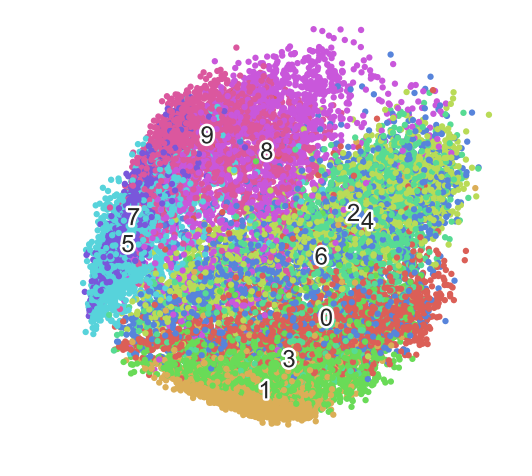

In [10]:
# On prend la première et seconde composante principale
top_two_comp = pca_df[['pca1','pca2']]

fashion_scatter(top_two_comp.values,y_subset) # On affiche le résultat de l'ACP

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

* On observant le scatter-plot, il est difficile de différencier une classe d'une autre. Néanmoins la catégorie "chaussure" (Sandal, Boot, Sneaker) est séparée des autres catégories (mis à part Bag).

* Même si dans l'ensemble il est difficile de différencier les classes, le cluster Trouser(1) se démarque et dans un moindre degré le cluster Dress

##### POINT IMPORTANT : la position des nombres qui permettent d'identifier les classes sur le scatter-plot à son importance. Elle correspond à la position du 'milieu' des points de la classe à laquelle ils se rapportent. La position exacte est donnée dans le tableau juste au-dessus du scatter-plot.

### Exemple d'image originale

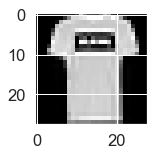

In [11]:
plt.figure(figsize=(2, 10))
plt.imshow(x_subset[1].reshape(28,28), 
           cmap = plt.cm.gray, 
           interpolation='nearest', 
           clim=(0, 255));
plt.imshow(x_train[1].reshape(28,28), cmap = plt.cm.gray);

### La même image reconstruite pour chaque digit

In [12]:
reconstruction = pca.inverse_transform(pca_result)

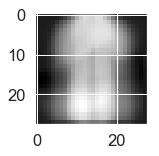

In [13]:
plt.figure(figsize=(2, 10))
plt.imshow(reconstruction[1].reshape(28,28), cmap = plt.cm.gray);

### Autre exemple

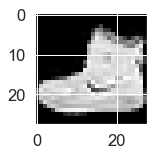

In [14]:
plt.figure(figsize=(2, 10))
plt.imshow(x_subset[0].reshape(28,28), 
           cmap = plt.cm.gray, 
           interpolation='nearest', 
           clim=(0, 255));
plt.imshow(x_train[0].reshape(28,28), cmap = plt.cm.gray);

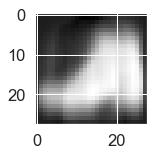

In [15]:
plt.figure(figsize=(2, 10))
plt.imshow(reconstruction[0].reshape(28,28), cmap = plt.cm.gray);

<br />
<br />

# 2. Réduction de dimension pour Fashion-MNIST avec t-SNE

In [16]:
from sklearn.manifold import TSNE
import time
RS = 123

##### Explication sur le 'random_state' de la fonction TSNE de sklearn :

###### "Some algorithms use the random numbers in initialization of certain parameters, such as weights for optimizing, splitting of data randomly into train and test, choosing some features etc.

###### Now in programming and software in general, nothing is inherently truly random. To generate random numbers, a program is used. But since its a program with some fixed steps, it cannot be truly random. So its called pseudorandom generators. Now to output different sequence of numbers each time, they take an input according to which numbers are generated. Typically, this input is the current time in milliseconds (Epochs UTC). This input is called seed. Fixing the seed means to fix the output numbers.

######  'random_state' is used as seed for pseudorandom number generator in scikit-learn to duplicate the behavior when such randomness is involved in algorithms. When a fixed random_state, it will produce exact same results in different runs of the program. So its easier to debug and identify problems, if any. Without setting the random_state, different seeds will be used each time that algorithm is run and you will get different results. It may happen that you may get very high scores first time and can never be able to achieve that again.

###### Now in machine learning, we want to replicate our steps exactly same as performed before, to analyse the results. Hence random_state is fixed to some integer."

###### source: "https://stackoverflow.com/questions/43321394/what-is-random-state-parameter-in-scikit-learn-tsne"

<br />
On utilise l'algorithme t-SNE avec deux composantes (n_components=2)

In [17]:
time_start = time.time()

fashion_tsne = TSNE(n_components=2, random_state=RS).fit_transform(x_subset)

print('t-SNE terminé! Temps écoulé: {} secondes'.format(time.time()-time_start))

t-SNE terminé! Temps écoulé: 888.7949259281158 secondes


(<Figure size 576x576 with 1 Axes>,
 [Text(41.57853, 6.2938895, '0'),
  Text(16.529232, 61.37285, '1'),
  Text(13.9984, -39.075554, '2'),
  Text(23.668945, 24.115776, '3'),
  Text(31.92881, -32.853615, '4'),
  Text(-36.646145, 5.3290944, '5'),
  Text(16.96063, -17.384825, '6'),
  Text(-59.432877, -11.076068, '7'),
  Text(-22.520933, -37.156204, '8'),
  Text(-34.86377, 39.52498, '9')])

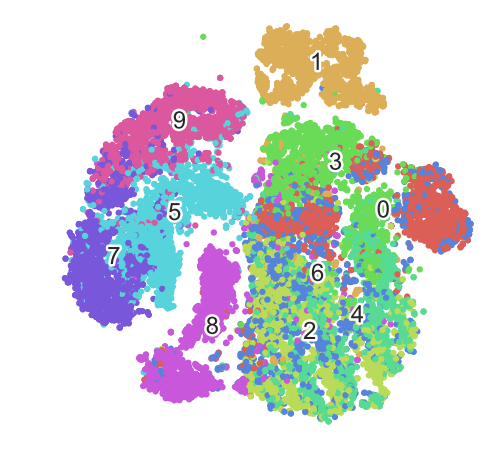

In [18]:
fashion_scatter(fashion_tsne, y_subset)    

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

* On peut voir que les individus sont plus clairement dans chacun de leur groupe.

* Comme pour la question 1, la catégorie "Chaussure" est bien séparée des autres mais cette fois les clusters Ankle boot(9), Sandal(5), Trouser(1), Sneaker(7) qui la compose sont bien distincts entre eux. 

* Le cluster Bag qui se confondait avec la catégorie 'Chaussure' dans l'ACP s'est maintenant séparée de celle-ci.

* Par ailleurs le cluster Trouser est maintenant lui aussi séparé des autres.

* La catégorie 'Haut' (T-shirt/top, Dress, Coat, Shirt) est comme dans l'ACP confondu (ce qui d'une certaine manière logique surtout pour ce qui est de Pullover(2) et Coat(4)).

<br />

La documentation du t-SNE de Scikit-learn dit explicitement :
###### "It is highly recommended to use another dimensionality reduction method (e.g., PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g., 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples."

C'est pourquoi nous allons d'abord réduire le nombre de dimensions avant de passer les données en entrée à l'algorithme t-SNE. 
Pour cela on utilise une ACP, on créé un nouveau jeu de données contenant les cinquante dimensions générées par l'ACP avant d'utiliser ce jeu pour faire le t-SNE. 

In [19]:
time_start = time.time()

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(x_subset)

print('ACP avec 50 composantes terminée ! Temps écoulé: {} secondes'
      .format(time.time()-time_start)
     )

print('Variance cumulée des 50 principales composantes: {}'
      .format(np.sum(pca_50.explained_variance_ratio_))
     )

ACP avec 50 composantes terminée ! Temps écoulé: 1.4085278511047363 secondes
Variance cumulée des 50 principales composantes: 0.8625020967033351


In [20]:
import time
time_start = time.time()

# On applique le t-SNE sur le résultat de l'ACP à 50 composantes
fashion_pca_tsne = TSNE(n_components = 2, 
                        random_state=RS
                       ).fit_transform(pca_result_50)

print('t-SNE terminé! Temps écoulé: {} secondes'.format(time.time()-time_start))

t-SNE terminé! Temps écoulé: 278.80045104026794 secondes


(<Figure size 576x576 with 1 Axes>,
 [Text(4.7901583, 20.149218, '0'),
  Text(26.375782, 59.060097, '1'),
  Text(20.152853, -40.924942, '2'),
  Text(48.392845, 18.192986, '3'),
  Text(36.210846, -34.156387, '4'),
  Text(-36.511497, 3.6258798, '5'),
  Text(14.379446, -18.8758, '6'),
  Text(-61.194073, -16.07289, '7'),
  Text(-19.05954, -34.976486, '8'),
  Text(-39.997803, 43.240032, '9')])

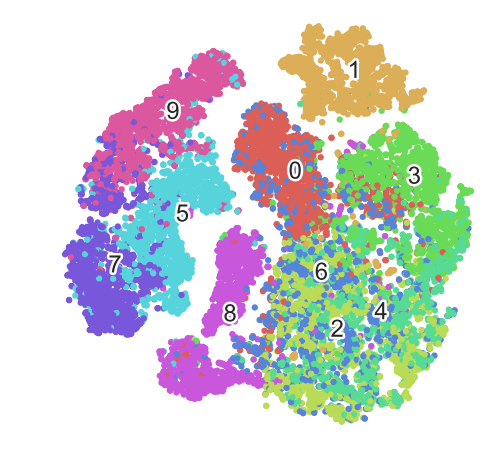

In [21]:
fashion_scatter(fashion_pca_tsne, y_subset)

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

* Le scatter-plot est plus ou moins similaire au précédent si ce n'est pour une seule différence. 
* Les points correspondant au label 0 (T-shirt/top) forment maintenant un cluster bien plus distinct.

### Etude des hyperparameters

##### Sans réduction du nombre de dimensions par ACP

###### Avec perplexity = 2

(<Figure size 576x576 with 1 Axes>,
 [Text(20.84661, 52.128513, '0'),
  Text(-18.342922, 46.558502, '1'),
  Text(22.211061, -33.174965, '2'),
  Text(63.940357, 16.953815, '3'),
  Text(45.286938, -22.528595, '4'),
  Text(-28.349655, -24.973251, '5'),
  Text(22.707474, -5.613823, '6'),
  Text(-25.844887, -61.590904, '7'),
  Text(-42.312874, -22.979557, '8'),
  Text(-67.4016, 32.866905, '9')])

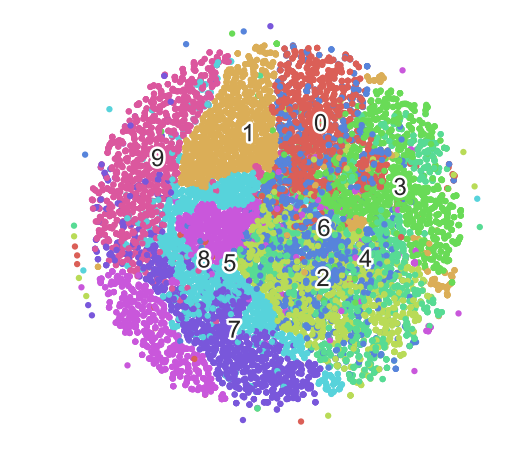

In [26]:
fashion_tsne = TSNE(n_components=2, 
                    random_state=RS, 
                    perplexity=2).fit_transform(x_subset)
fashion_scatter(fashion_tsne, y_subset)

###### Avec perplexity = 5

(<Figure size 576x576 with 1 Axes>,
 [Text(28.302555, 40.796566, '0'),
  Text(-2.4202764, 66.92145, '1'),
  Text(19.013687, -43.064068, '2'),
  Text(65.57915, 12.33606, '3'),
  Text(39.850952, -39.548405, '4'),
  Text(-28.66306, 9.316994, '5'),
  Text(22.307468, -15.126082, '6'),
  Text(-50.50521, -18.802359, '7'),
  Text(-39.779865, -60.741432, '8'),
  Text(-58.396637, 44.534977, '9')])

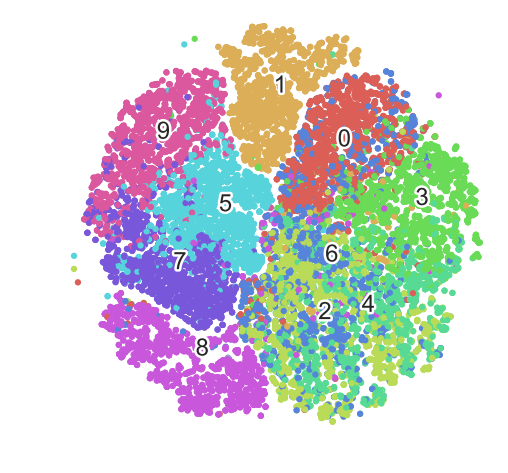

In [27]:
fashion_tsne = TSNE(n_components=2, 
                    random_state=RS, 
                    perplexity=5).fit_transform(x_subset)
fashion_scatter(fashion_tsne, y_subset)

###### Avec perplexity = 30

(<Figure size 576x576 with 1 Axes>,
 [Text(41.57853, 6.2938895, '0'),
  Text(16.529232, 61.37285, '1'),
  Text(13.9984, -39.075554, '2'),
  Text(23.668945, 24.115776, '3'),
  Text(31.92881, -32.853615, '4'),
  Text(-36.646145, 5.3290944, '5'),
  Text(16.96063, -17.384825, '6'),
  Text(-59.432877, -11.076068, '7'),
  Text(-22.520933, -37.156204, '8'),
  Text(-34.86377, 39.52498, '9')])

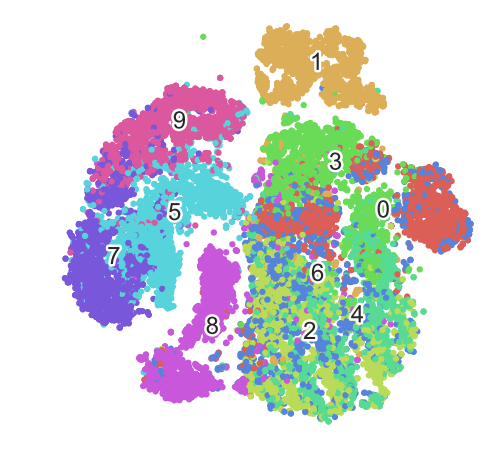

In [28]:
fashion_tsne = TSNE(n_components=2, 
                    random_state=RS, 
                    perplexity=30).fit_transform(x_subset)
fashion_scatter(fashion_tsne, y_subset)

###### Avec perplexity = 50

(<Figure size 576x576 with 1 Axes>,
 [Text(37.199284, 4.252836, '0'),
  Text(18.435268, 54.4959, '1'),
  Text(10.811766, -36.27677, '2'),
  Text(22.990936, 20.220346, '3'),
  Text(27.242733, -31.541576, '4'),
  Text(-34.62475, 6.991124, '5'),
  Text(14.438634, -16.702396, '6'),
  Text(-55.505947, -5.9991665, '7'),
  Text(-22.495943, -34.29942, '8'),
  Text(-30.099167, 36.925606, '9')])

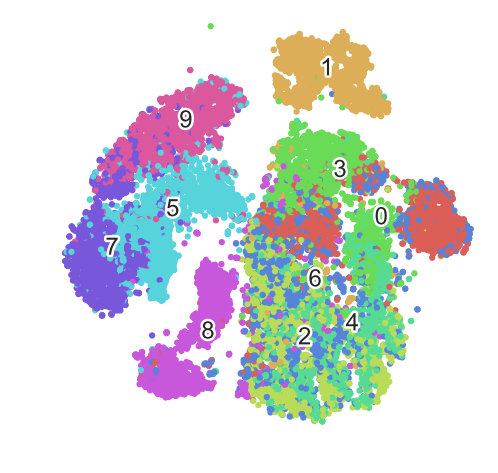

In [29]:
fashion_tsne = TSNE(n_components=2, 
                    random_state=RS, 
                    perplexity=50).fit_transform(x_subset)
fashion_scatter(fashion_tsne, y_subset)

###### Avec perplexity = 100

(<Figure size 576x576 with 1 Axes>,
 [Text(31.150927, 2.4574032, '0'),
  Text(18.660587, 45.604183, '1'),
  Text(8.282235, -30.467094, '2'),
  Text(22.169575, 16.265154, '3'),
  Text(18.909122, -26.11355, '4'),
  Text(-30.781612, 6.4428244, '5'),
  Text(10.220851, -14.705719, '6'),
  Text(-48.455036, -0.9920517, '7'),
  Text(-20.752657, -30.110775, '8'),
  Text(-25.29903, 31.575142, '9')])

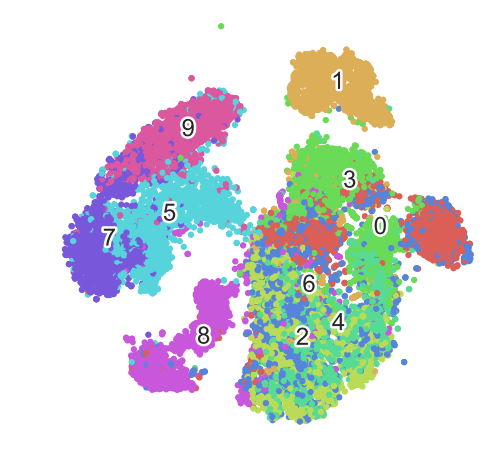

In [30]:
fashion_tsne = TSNE(n_components=2, 
                    random_state=RS, 
                    perplexity=100).fit_transform(x_subset)
fashion_scatter(fashion_tsne, y_subset)

* Pour le t-SNE sans réduction de dimensions, on observe que le scatter-plot avec une perplexité de 5 est celui qui permet le mieux de différencier les clusters.

<br />

##### Avec réduction du nombre de dimensions par ACP

###### Avec perplexity = 2

(<Figure size 576x576 with 1 Axes>,
 [Text(11.389861, 53.972282, '0'),
  Text(-32.627296, 23.681496, '1'),
  Text(-0.9375009, -42.928394, '2'),
  Text(58.386326, 17.79972, '3'),
  Text(26.61019, -29.52015, '4'),
  Text(-2.5715778, 8.480616, '5'),
  Text(2.443925, -22.293798, '6'),
  Text(27.17799, -45.588444, '7'),
  Text(-50.308056, -34.705307, '8'),
  Text(-60.290962, 50.80867, '9')])

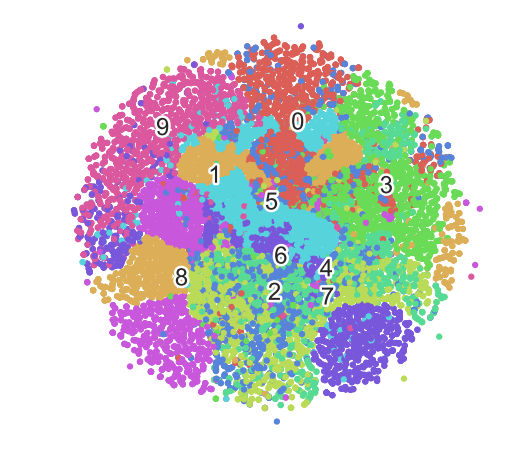

In [31]:
fashion_pca_tsne = TSNE(n_components=2, 
                        random_state=RS, 
                        perplexity=2).fit_transform(pca_result_50)    
fashion_scatter(fashion_pca_tsne, y_subset)

###### Avec perplexity = 5

(<Figure size 576x576 with 1 Axes>,
 [Text(27.736551, 43.702625, '0'),
  Text(-5.665308, 62.566975, '1'),
  Text(21.175817, -44.0736, '2'),
  Text(65.21658, 16.77093, '3'),
  Text(42.571724, -38.441246, '4'),
  Text(-31.366278, 11.914782, '5'),
  Text(25.174688, -16.145348, '6'),
  Text(-45.051258, -21.19962, '7'),
  Text(-40.348434, -63.055954, '8'),
  Text(-66.165924, 39.4351, '9')])

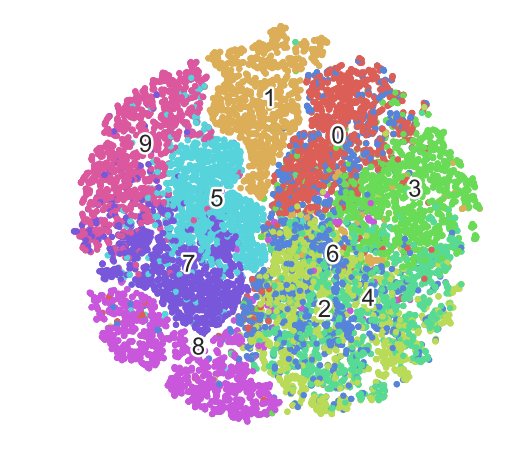

In [32]:
fashion_pca_tsne = TSNE(n_components=2, 
                        random_state=RS, 
                        perplexity=5).fit_transform(pca_result_50)    
fashion_scatter(fashion_pca_tsne, y_subset)

###### Avec perplexity = 30

(<Figure size 576x576 with 1 Axes>,
 [Text(4.7901583, 20.149218, '0'),
  Text(26.375782, 59.060097, '1'),
  Text(20.152853, -40.924942, '2'),
  Text(48.392845, 18.192986, '3'),
  Text(36.210846, -34.156387, '4'),
  Text(-36.511497, 3.6258798, '5'),
  Text(14.379446, -18.8758, '6'),
  Text(-61.194073, -16.07289, '7'),
  Text(-19.05954, -34.976486, '8'),
  Text(-39.997803, 43.240032, '9')])

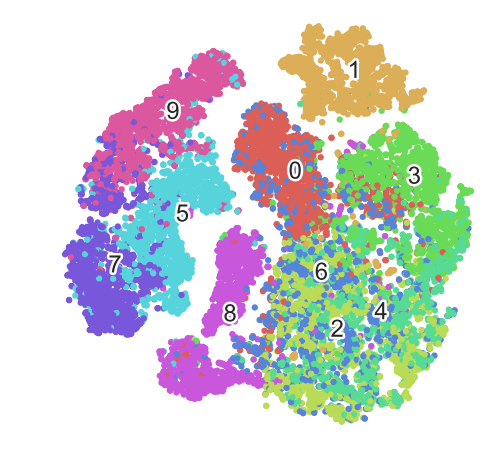

In [33]:
fashion_pca_tsne = TSNE(n_components=2, 
                        random_state=RS, 
                        perplexity=30).fit_transform(pca_result_50)    
fashion_scatter(fashion_pca_tsne, y_subset)

###### Avec perplexity = 50

(<Figure size 576x576 with 1 Axes>,
 [Text(47.851997, 2.5212624, '0'),
  Text(17.493763, 53.563652, '1'),
  Text(10.7650385, -37.82168, '2'),
  Text(29.596178, 20.5036, '3'),
  Text(26.615496, -33.073227, '4'),
  Text(-35.810196, 8.4079685, '5'),
  Text(14.656103, -18.826595, '6'),
  Text(-57.62471, -6.3661757, '7'),
  Text(-21.860264, -28.556211, '8'),
  Text(-32.67462, 40.76061, '9')])

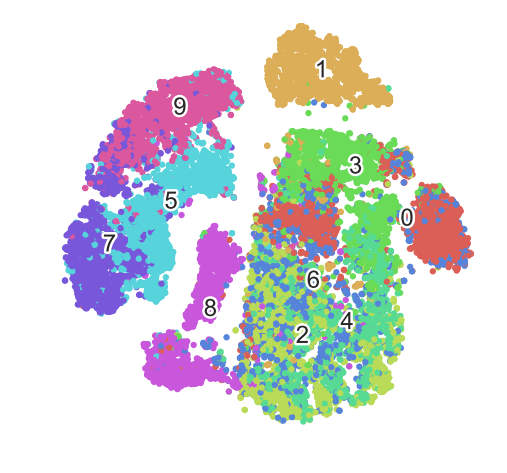

In [34]:
fashion_pca_tsne = TSNE(n_components=2, 
                        random_state=RS, 
                        perplexity=50).fit_transform(pca_result_50)    
fashion_scatter(fashion_pca_tsne, y_subset)

###### Avec perplexity = 100

(<Figure size 576x576 with 1 Axes>,
 [Text(40.026886, 0.86331713, '0'),
  Text(14.077668, 45.81776, '1'),
  Text(8.859262, -32.02784, '2'),
  Text(27.699139, 16.841686, '3'),
  Text(21.17536, -28.011042, '4'),
  Text(-33.037663, 7.113573, '5'),
  Text(14.218857, -15.8333235, '6'),
  Text(-50.85297, -3.3459945, '7'),
  Text(-19.125544, -26.29206, '8'),
  Text(-29.3874, 33.713234, '9')])

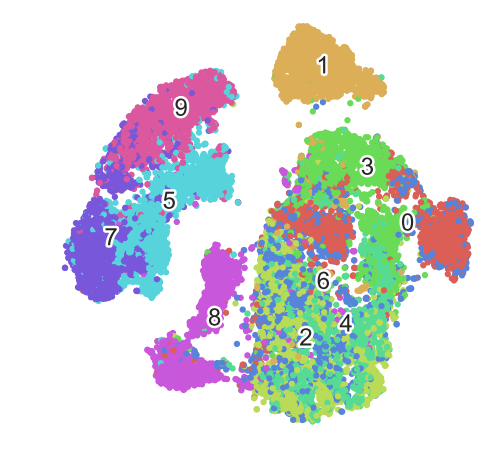

In [35]:
fashion_pca_tsne = TSNE(n_components=2, 
                        random_state=RS, 
                        perplexity=100).fit_transform(pca_result_50)    
fashion_scatter(fashion_pca_tsne, y_subset)

* Encore une fois, le scatter-plot avec une perplexité de 5 est celui qui permet le mieux de différencier les clusters.